In [10]:
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
#Chargement d'un ensemble de données de faces de personnages connus
from sklearn.datasets import fetch_lfw_people

In [12]:
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [15]:
#format des images et nombres de clusters
print("Format des images: {}".format(faces.images.shape))
print("Nombre de classes: {}".format(len(faces.target_names)))

Format des images: (3023, 87, 65)
Nombre de classes: 62


In [16]:
#nombre de données par cluster
nombres = np.bincount(faces.target)
for i, (nb, nom) in enumerate(zip(nombres, faces.target_names)):
    print("{0:25} {1:3}".format(nom, nb), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

<IPython.core.display.Javascript object>


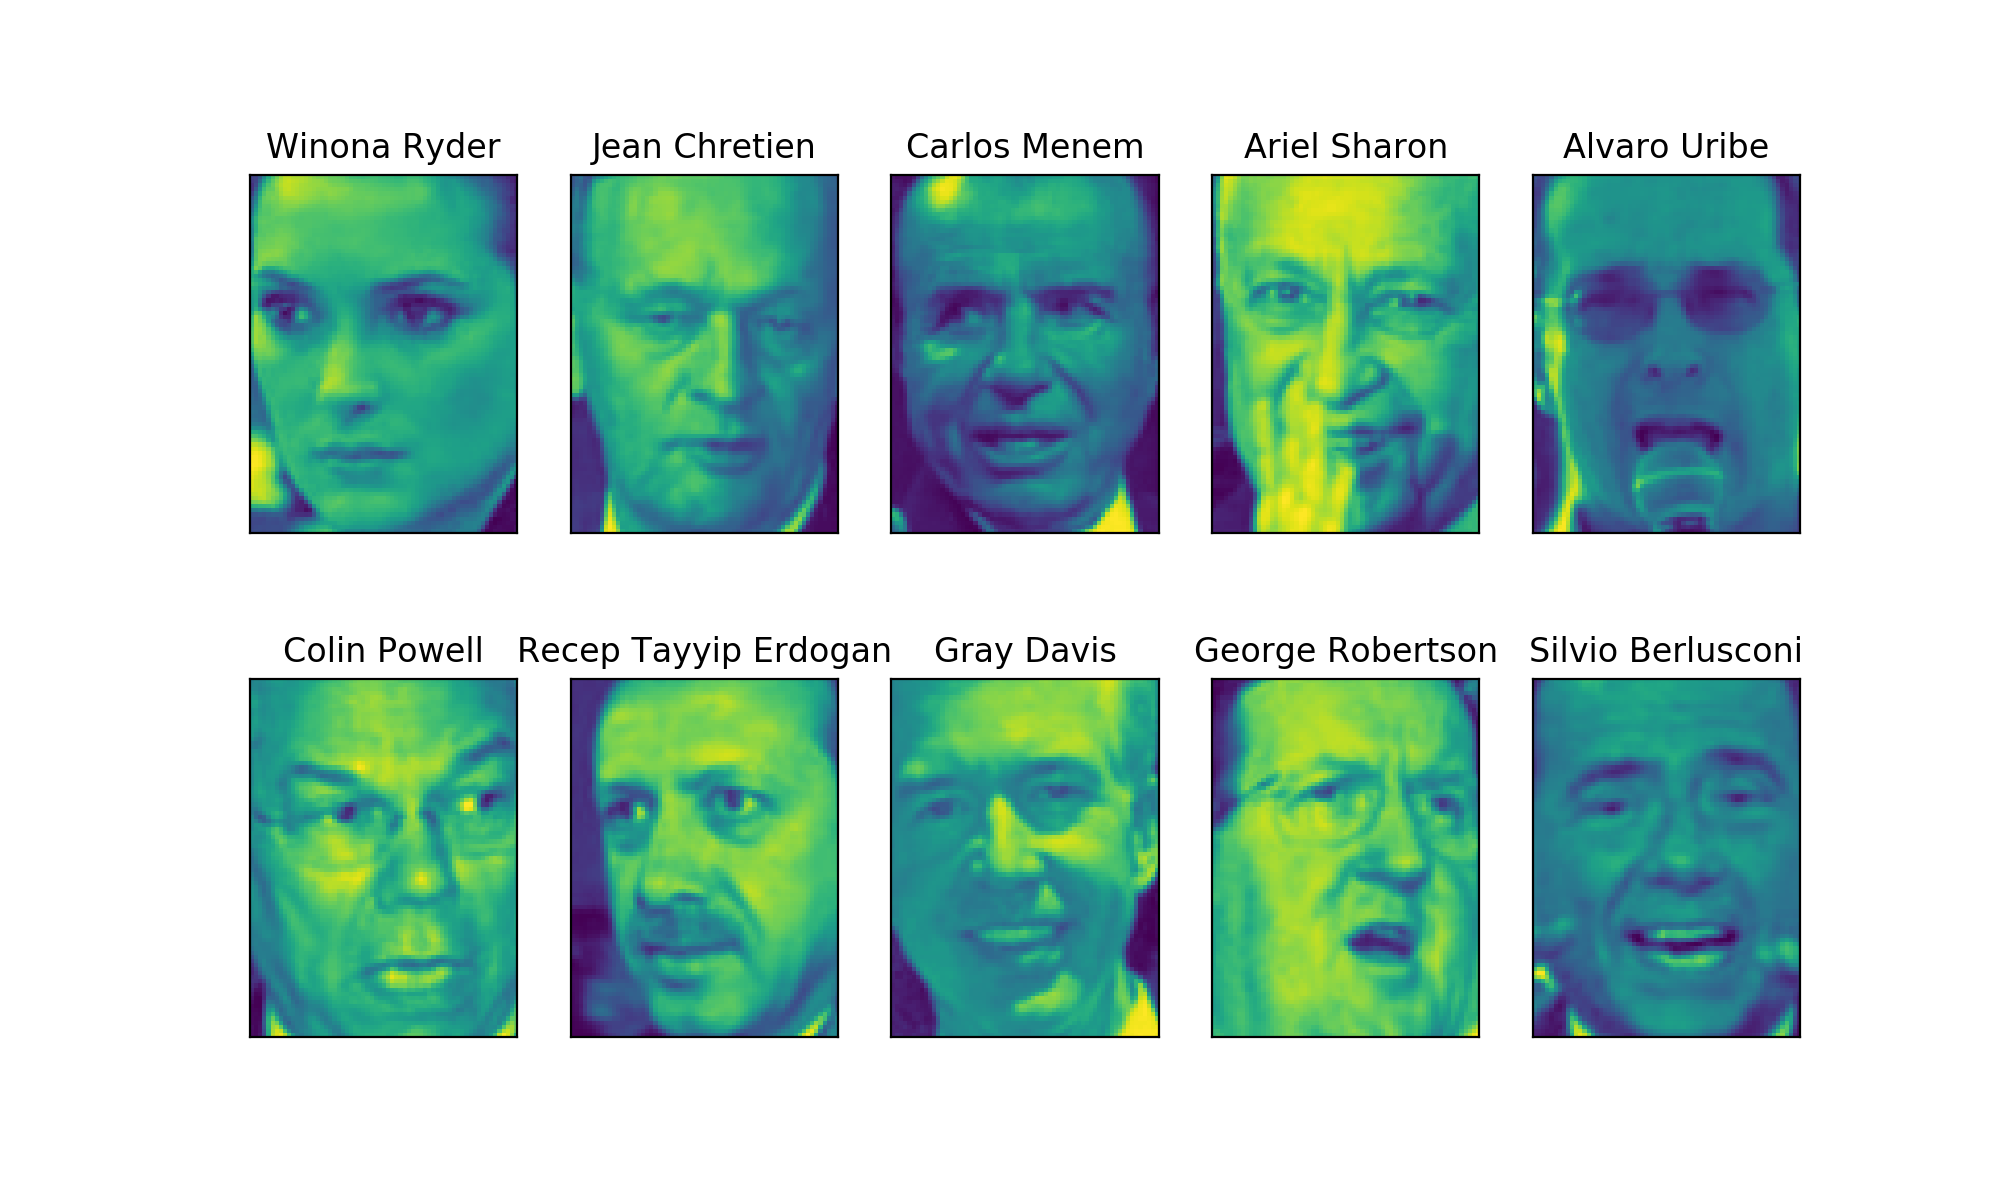

In [17]:
#Affichage des 10 premières faces
fig, axes = plt.subplots(2, 5, figsize=(10, 6),
                         subplot_kw={'xticks': (), 'yticks': ()})
for nom, image, ax in zip(faces.target, faces.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(faces.target_names[nom])